In [2]:
# PLOT RECOVERED OMEGA_GW
import sys
import transdimensional_spline_fitting as tsf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import norm
from scipy.optimize import minimize
from functools import partial
import matplotlib as mpl
import pandas as pd
from scipy.interpolate import interp1d

mpl.rcParams.update(mpl.rcParamsDefault)

import pygwb
import bilby
import astropy.cosmology
from copy import deepcopy
from pygwb.baseline import Baseline
import seaborn as sns

from popstock_tsf_helper import *

# Signficantly speeds things up
import lal
lal.swig_redirect_standard_output_error(False)

R0 = 31.4
H0 = astropy.cosmology.Planck18.H0.to(astropy.units.s**-1).value

class SmoothCurveDataObj(object):
    """
    A data class that can be used with our spline model
    """
    def __init__(self, data_xvals, data_yvals, data_errors):
        self.data_xvals = data_xvals
        self.data_yvals = data_yvals
        self.data_errors = data_errors

class FitRedshift(tsf.BaseSplineModel):
    """
    Example of subclassing `BaseSplineModel` to create a likelihood
    that can then be used for sampling.

    Assumes use with `ArbitraryCurveDataObj`

    You also need to create a simple data class to go along with this. This
    allows the sampler to be used with arbitrary forms of data...
    """
    def ln_likelihood(self, config, heights):
        """
        Simple Gaussian log likelihood where the data are just simply
        points in 2D space that we're trying to fit.

        This could be something more complicated, though, of course. For example,
        You might create your model from the splines (`model`, below) and then use that
        in some other calculation to put it into the space for the data you have.

        :param data_obj: `ArbtraryCurveDataObj` -- an instance of the data object class associated with this likelihood.
        :return: log likelihood
        """
        # be careful of `evaluate_interp_model` function! it does require you to give a list of xvalues,
        # which don't exist in the base class!
        redshift_model = 10**self.evaluate_interp_model(np.log10(bbh_pickle.ref_zs), heights, config, log_xvals=True)
        
        model = bbh_pickle.eval(R0, redshift_model, self.data.data_xvals)
        
        return np.sum(norm.logpdf(model - self.data.data_yvals, scale=self.data.data_errors))

class FitOmega(tsf.BaseSplineModel):
    """
    Example of subclassing `BaseSplineModel` to create a likelihood
    that can then be used for sampling.

    Assumes use with `ArbitraryCurveDataObj`

    You also need to create a simple data class to go along with this. This
    allows the sampler to be used with arbitrary forms of data...
    """

    
    def ln_likelihood(self, config, heights, knots):
        """
        Simple Gaussian log likelihood where the data are just simply
        points in 2D space that we're trying to fit.

        This could be something more complicated, though, of course. For example,
        You might create your model from the splines (`model`, below) and then use that
        in some other calculation to put it into the space for the data you have.

        :param data_obj: `ArbtraryCurveDataObj` -- an instance of the data object class associated with this likelihood.
        :return: log likelihood
        """
        # be careful of `evaluate_interp_model` function! it does require you to give a list of xvalues,
        # which don't exist in the base class!
        omega_model = 10**self.evaluate_interp_model(np.log10(self.data.data_xvals), heights, config, np.log10(knots))
        # print(omega_model)
        # print(self.data.data_yvals)
        # print(self.data.data_errors)

        return np.sum(norm.logpdf(omega_model - self.data.data_yvals, scale=self.data.data_errors))



/home/tknapp/miniconda3/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [18]:
# VARIABLES   
freqs = np.arange(20, 100, 0.03125)

T = 365.25* 24 * 60 * 60 *10

T = 365.25*1000* 24* 60 * 60

#N_samples = 1_000_000
N_samples = 100_000
N_offset = 10_000

# generate data given a keyword ['BPL', 'squiggly', 'Sachdev'] - currently using a txt file for the Sachdev curve
sig_type = 'classic'
noise_type = 'HL'

freqs, data, signal, fit_omega, fit_results_omega = pickle.load(open(f'{sig_type}_signal_data_{T/(24 * 60 * 60)}_{noise_type}.pkl', 'rb'))

for i in np.arange(len(return_knot_heights(fit_results_omega)[0])//5):
    plt.loglog(np.arange(len(return_knot_heights(fit_results_omega)[:,i])), return_knot_heights(fit_results_omega)[:,i], alpha=0.5)
plt.xlabel('Sample num')
plt.ylabel('Knot height')


Text(0, 0.5, 'Knot height')

In [19]:
plt.hist(fit_results_omega.move_types)

(array([19994.,     0., 19978.,     0.,     0., 19917.,     0.,
        20123.,     0., 19988.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

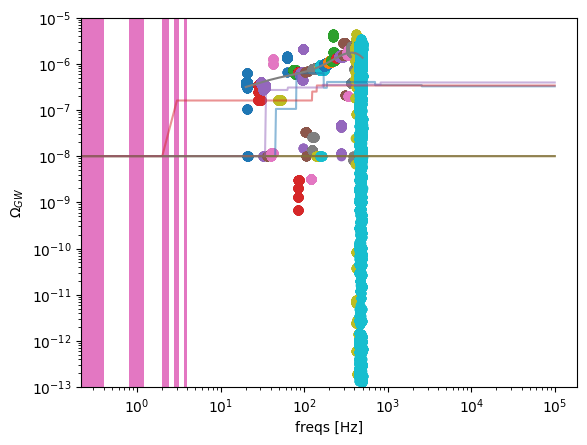

In [20]:
plot_knot_placements(freqs, signal, fit_results_omega, toggle=True)


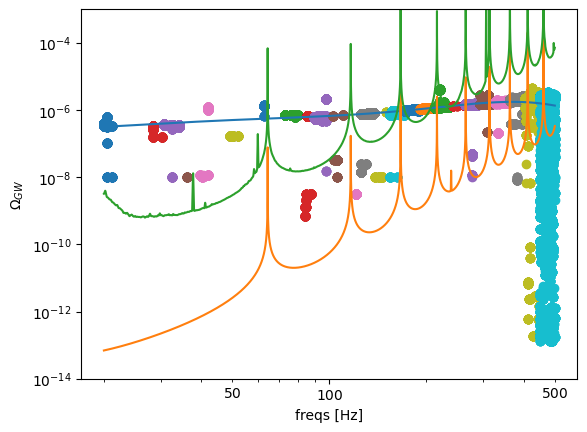

In [23]:
toggle=True
xs = return_knot_frequencies(fit_results_omega, offset=1000, toggle=toggle)
ys = return_knot_heights(fit_results_omega, offset=1000, toggle=toggle)
if toggle: 
    for i in range(len(xs)):
        plt.scatter(xs[i], ys[i])
else: 
    plt.scatter(xs, ys)

plt.loglog(freqs, signal)
#plt.xlim(min(freqs), max(freqs))
plt.ylim(1e-14, 1e-3)
plt.yscale('log')
plt.xlabel('freqs [Hz]')
plt.ylabel('$\Omega_{GW}$')

sigma_curve = get_sigma_from_noise_curves(['CE'], freqs, T)
plt.loglog(freqs, sigma_curve)
sigma_curve = get_sigma_from_noise_curves(['H1', 'L1'], freqs, T)
plt.loglog(freqs, sigma_curve)
plt.show()

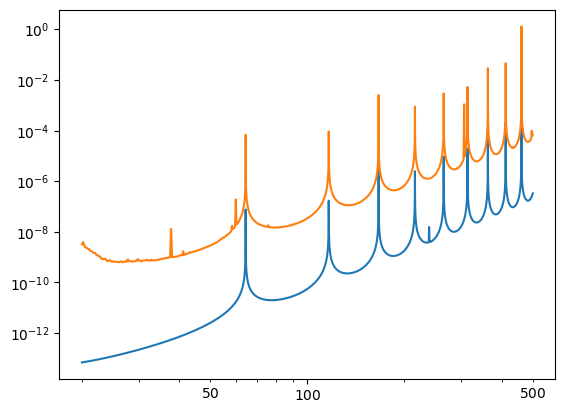

In [22]:
sigma_curve = get_sigma_from_noise_curves(['CE'], freqs, T)
plt.loglog(freqs, sigma_curve)
sigma_curve = get_sigma_from_noise_curves(['H1', 'L1'], freqs, T)
plt.loglog(freqs, sigma_curve)
plt.show()

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
dataa = [np.random.normal(loc, 1, 100) for loc in range(5)]  # Five distributions

Tvals = [7* 24 * 60 * 60, 14* 24 * 60 * 60, 30* 24 * 60 * 60,      
         168* 24 * 60 * 60,      365.25* 24 * 60 * 60,       365.25*2* 24 * 60 * 60, 
        365.25*5* 24 * 60 * 60,        365.25*10* 24* 60 * 60, 365.25*20* 24 * 60 * 60, 
        365.25*50* 24 * 60 * 60,      365.25*100* 24 * 60 * 60, 365.25*500* 24 * 60 * 60, 365.25*1000* 24 * 60 * 60]   

N_samples = 500_000
N_offset = 10_000

sig_type = 'FOPT'
noise = 'CE'

num_knots_array = []
actual_Ts = []

for kk, T in enumerate(Tvals): 
    print(f'TIME: {T}')
    try:
        freqs, data, signal, fit_omega, fit_results_omega = pickle.load(open(f'{sig_type}_signal_data_{T/(24 * 60 * 60)}_{noise}.pkl', 'rb'))

        plt.clf()
        
        configs, num_knots = return_knot_info(fit_results_omega, offset=N_offset)
        num_knots_array.append(num_knots)
        actual_Ts.append(T/(365.25* 24 * 60 * 60))
    except: print('oopsie')

TIME: 604800
TIME: 1209600
TIME: 2592000
TIME: 14515200
TIME: 31557600.0
TIME: 63115200.0
TIME: 157788000.0
TIME: 315576000.0
TIME: 631152000.0
TIME: 1577880000.0
TIME: 3155760000.0
oopsie
TIME: 15778800000.0
oopsie
TIME: 31557600000.0
oopsie


In [ ]:
# Create violin plot
plt.violinplot(num_knots_array, positions = np.log10(actual_Ts), showmeans=True, showextrema=False, showmedians=False, vert=True)
plt.xlabel("T_obs [yrs]")
plt.ylabel("Number of Knots")
plt.xticks(np.arange(-1,3), labels = [0.1,1,10,100])
#plt.xscale('log')
plt.ylim(-1, 20)
plt.tight_layout()
plt.savefig(f'num_knots_violin_{sig_type}_{noise}.pdf')
plt.show()